<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Experimental-Setup" data-toc-modified-id="Experimental-Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Experimental Setup</a></span></li><li><span><a href="#Notebook-Setup" data-toc-modified-id="Notebook-Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Notebook Setup</a></span></li><li><span><a href="#Get-CitiBike-Data" data-toc-modified-id="Get-CitiBike-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get CitiBike Data</a></span></li><li><span><a href="#Clean-up-data" data-toc-modified-id="Clean-up-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clean up data</a></span></li><li><span><a href="#Explore-the-data" data-toc-modified-id="Explore-the-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Explore the data</a></span></li><li><span><a href="#Test-the-difference-of-age-proportions" data-toc-modified-id="Test-the-difference-of-age-proportions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test the difference of age proportions</a></span><ul class="toc-item"><li><span><a href="#Use-a-Z-Test-for-equality-of-proportions" data-toc-modified-id="Use-a-Z-Test-for-equality-of-proportions-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Use a Z-Test for equality of proportions</a></span></li><li><span><a href="#Use-a-Chi-Square-Test-for-equality-of-proportions" data-toc-modified-id="Use-a-Chi-Square-Test-for-equality-of-proportions-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Use a Chi Square Test for equality of proportions</a></span></li></ul></li></ul></div>

# Are younger people more likely to use bikeshare than older people?

## Experimental Setup

Bikeshare in NYC is a great way to get around town. It offers a mode of transport that takes up less road space, encourages exercise, does not emit greenhouse gases, and is cheaper than other forms of transit. However, it is limiting in its accessibility in terms of physical disabilities.

If we accept the hypothesis that as one ages, one's physical abilities decrease, we would then predict to see that CitiBike has a distinct age difference in users. If we see this, this would perhaps give impetus for the argument of adding electric bicycles to the fleet to open up cycling to a larger swathe of the population.

First, we must define what we mean by old and young. To do this, we did cursory research in the field of gerontology. By no means was this an extensive and exhaustive investigation. We used an [article](https://www.aarp.org/health/healthy-living/info-2016/fitness-aging-physical-decline-cs.html) from the Association of American Retired Persons (AARP) which quotes an article from the Journal on Gerontology that says that physical abilities begin to markedly decline in a person's 50s. This is, of course, a generalization that averages different variables such as gender and nationality. But we shall use this as our cutoff with the thesis that at age 50 and older, a user may have greater difficulty in using the CitiBike system. 

<center>**Null Hypothesis**<center>

The proportion of users who are classified as young is the same as the proportion of users who are classified as old. 
    
$$H_0: \pi_{young} = \pi_{old}$$

<center>**Alternative Hypothesis**<center>
    
_One Sided_: The proportion of users who are classified as young is higher than the proportion of users who are classified as old. 
    
_Two Sided_: The proportion of users who are classified as young is the not the same as the proportion of users who are classified as old. 
    
$$H_a: \pi_{young} > \pi_{old}$$
$$H_a: \pi_{young} \neq \pi_{old}$$

It is important to note that since we have made our data binary - a user is either young or old - then the null hypothesis is that each proportion is 50% whereas in the alternative one tailed hypothesis, the young proportion is greater than 50% and the old proportion is less than 50%. Because of this binary nature, we can look at the proportions as success or failure. This makes the Chi Square Equality of Proportions test the appropriate one. 

## Notebook Setup

In [73]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import scipy.stats as stats
import glob
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Get CitiBike Data

In [2]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will check that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [9]:
#We want a large sample of data to smooth out any other unobservables such as time of year,
#holidays, etc.
datestrings = ['201601', '201608', '201501', '201508']

for string in datestrings:
    getCitiBikeCSV(string)

file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue


In [41]:
#We use this to read and concatenate all the csvs at the same time
#Warning: your PUIDATA folder must be empty of other CSVs or else...
path = os.getenv("PUIDATA")                 
allFiles = glob.glob(os.path.join(path, "*-citibike-tripdata.csv"))  

allDF = (pd.read_csv(f) for f in allFiles)
df = pd.concat(allDF, ignore_index=True)

In [42]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


## Clean up data

In [45]:
#Let's make sure we have a year column to know when the data is from
df['date'] = pd.to_datetime(df['starttime'])

AttributeError: 'Series' object has no attribute 'year'

In [50]:
df['year'] = df['date'].dt.year

In [51]:
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype','gender'], axis=1, inplace=True)
df.head()

,birth year,date,year
0,1960.0,2015-01-01 00:01:00,2015
1,1963.0,2015-01-01 00:02:00,2015
2,1974.0,2015-01-01 00:04:00,2015
3,1969.0,2015-01-01 00:04:00,2015
4,1977.0,2015-01-01 00:05:00,2015


In [52]:
df['age'] = df['year'] - pd.to_numeric(df['birth year'])
df.head()

,birth year,date,year,age
0,1960.0,2015-01-01 00:01:00,2015,55.0
1,1963.0,2015-01-01 00:02:00,2015,52.0
2,1974.0,2015-01-01 00:04:00,2015,41.0
3,1969.0,2015-01-01 00:04:00,2015,46.0
4,1977.0,2015-01-01 00:05:00,2015,38.0


In [53]:
df = df.dropna()
df = df.drop(['birth year', 'date'], axis=1)

In [54]:
df.head()

,year,age
0,2015,55.0
1,2015,52.0
2,2015,41.0
3,2015,46.0
4,2015,38.0


## Explore the data

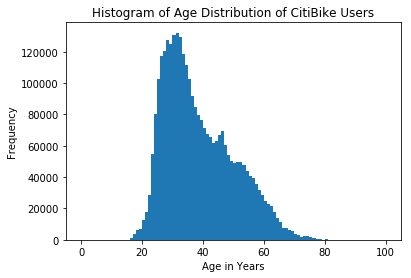

In [55]:
pl.hist(df.age, 100, (0,100));
title("Histogram of Age Distribution of CitiBike Users");
xlabel("Age in Years");
ylabel("Frequency");

**Figure 1:** A histogram of the distribution of the age of CitiBike users seems to show an almost Poissonian distribution favoring younger users. There may even be two peaks in the distribution.

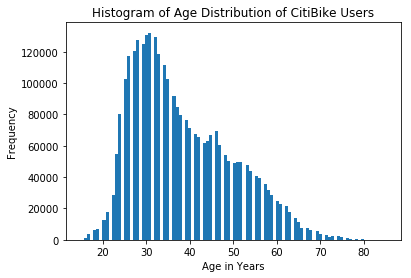

In [56]:
pl.hist(df.age, 100, (15,85));
title("Histogram of Age Distribution of CitiBike Users");
xlabel("Age in Years");
ylabel("Frequency");

**Figure 2:** By changing the upper and lower bounds for age in the histogram, we can see a clearer picture with users peaking around 30 and then decreasing from then on. If 30 is the modal age, perhaps we should also do an experiment where 30 is the cutoff. But for now, let us stick with 50 for its gerontological purposes. 

In [57]:
total = df.age.count()
print("Total number of users: " + str(total))

young = df[df.age < 50].count()
old = df[df.age > 50].count()

print("Number of users younger than 50: " + str(young))
print("Number of users older than 50: " + str(old))

youngRatio = young / total
oldRatio = old / total

print("Percentage who are younger than 50: " + str(youngRatio))
print("Percentage who are older than 50: " + str(oldRatio))

Total number of users: 3065939
Number of users younger than 50: year    2491889
age     2491889
dtype: int64
Number of users older than 50: year    525002
age     525002
dtype: int64
Percentage who are younger than 50: year    0.812765
age     0.812765
dtype: float64
Percentage who are older than 50: year    0.171237
age     0.171237
dtype: float64


## Test the difference of age proportions

### Use a Z-Test for equality of proportions

We can first use a z-test to test the equality of two proportions.

$$z = \dfrac{\hat{\pi} - \pi_0}{{se}_0}$$

$$se_0 = \sqrt{\frac{\pi_0(1-\pi_0)}{n}}$$

In [72]:
se = sqrt((youngRatio[0] * (1 - youngRatio[0])) / total)
z = (.50 - youngRatio[0]) / se
z = abs(z)

alpha = 0.05

if z <= 1.96:
    print("Insignificant. Do not reject the null hypothesis.")
else:
    print("Significant. Reject the null hypothesis.")

Significant. Reject the null hypothesis.


We have a z score much higher than the threshold of 1.96 meaning that the two proportions are different. We use the 50% as that is what it would be if they were the same. Using that 50%, we see then that the proportion of young users is most definitely not the same as the proportion of older users!

### Use a Chi Square Test for equality of proportions

Because we are testing whether two proportions from the same population are equal or not, the Chi Square test for equality of proportions is perhaps the most appropriate test. It is also appropriate because we are testing categorical data. Because we need a two by two matrix of outcomes, we use the two different years to see if the different proportions are the same across years.

In [82]:
y15Data = df[df['year'] == 2015]
y15Old = y15Data[y15Data.age < 50].count()
y15Young = y15Data[y15Data.age < 50].count()
y15Total = y15Data.age.count()

y16Data = df[df['year'] == 2016]
y16Old = y16Data[y16Data.age < 50].count()
y16Young = y16Data[y16Data.age < 50].count()
y16Total = y16Data.age.count()

In [86]:
y16Young = y16Young[0]
y15Young = y15Young[0]
y16Old = y16Old[0]
y15Old = y15Old[0]

In [88]:
contingencyTable = np.array([[y15Old, y15Young, y15Total], [y16Old, y16Young, y16Total]])

In [89]:
stats.chi2_contingency(contingencyTable)

(1.6094081331629175,
 0.44722025439700064,
 2,
 array([[ 1005479.74697011,  1005479.74697011,  1237109.50605978],
        [ 1486409.25302989,  1486409.25302989,  1828829.49394022]]))

The first value is the test statistic then followed by the p-value and then the degrees of freedom. As we see here, it is not significant. That is because we are only looking at two years. It would make sense to expand the number of years we look at to see if this distribution - this proportion of young to old - stays the same for each year. 